<a href="https://colab.research.google.com/github/FlorenceMawusi/Market-Prices-Prediction/blob/main/Market_Price_Time_Series_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#About:
---
Develop a time series machine learning model capable of forecasting market trends based on historical data.

# Imports


In [1]:
import os

import numpy as np
from google.colab import drive
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Load Data

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Colab/Machine Learning Internship MIP-ML-11/Market Price Prediction/MarketPricePrediction.csv', delimiter=',')
data.head(5)

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,January-2005
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,January-2006
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,January-2010
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,January-2011
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,January-2012


In [3]:
# prompt: Using dataframe data: Engineering: Create relevant features such as lagged variables,

# Create a lagged variable for quantity
data['quantity_lag1'] = data.groupby('market')['quantity'].shift(1)

# Create a lagged variable for priceMin
data['price_min_lag1'] = data.groupby('market')['priceMin'].shift(1)

# Create a lagged variable for priceMax
data['price_max_lag1'] = data.groupby('market')['priceMax'].shift(1)


In [4]:
data.describe()


,year,quantity,priceMin,priceMax,priceMod,quantity_lag1,price_min_lag1,price_max_lag1
count,10227.000000,1.022700e+04,10227.000000,10227.000000,10227.000000,1.010700e+04,10107.000000,10107.000000
mean,2009.022294,7.660488e+04,646.944363,1212.760731,984.284345,7.667354e+04,642.587613,1205.074998
std,4.372841,1.244087e+05,673.121850,979.658874,818.471498,1.244696e+05,670.923987,977.860199
min,1996.000000,2.000000e+01,16.000000,145.000000,80.000000,2.000000e+01,16.000000,145.000000
25%,2006.000000,8.898000e+03,209.000000,557.000000,448.000000,9.009500e+03,207.500000,554.000000
50%,2009.000000,2.746000e+04,440.000000,923.000000,747.000000,2.753000e+04,436.000000,910.000000
75%,2013.000000,8.835650e+04,828.000000,1527.000000,1248.000000,8.832600e+04,821.000000,1509.000000
max,2016.000000,1.639032e+06,6000.000000,8192.000000,6400.000000,1.639032e+06,6000.000000,6977.000000


# Data Preprocessing

In [5]:
# Convert date column to datetime format
data['date'] = pd.to_datetime(data['date'], format='%B-%Y')
data['date']

0       2005-01-01
1       2006-01-01
2       2010-01-01
3       2011-01-01
4       2012-01-01
           ...    
10222   2011-12-01
10223   2012-12-01
10224   2013-12-01
10225   2014-12-01
10226   2015-12-01
Name: date, Length: 10227, dtype: datetime64[ns]

In [6]:
# Show the number of duplicates and if any, remove them.

duplicate_rows = data[data.duplicated()]

print(f"Number of duplicate rows: {len(duplicate_rows)}")

if len(duplicate_rows):
  data = data.drop_duplicates()


Number of duplicate rows: 0


In [7]:
# Check for missing values

data.isnull().sum()


market              0
month               0
year                0
quantity            0
priceMin            0
priceMax            0
priceMod            0
state               0
city                0
date                0
quantity_lag1     120
price_min_lag1    120
price_max_lag1    120
dtype: int64

In [8]:
# Create new features
data['price_range'] = data['priceMax'] - data['priceMin']
data['price_mean'] = (data['priceMax'] + data['priceMin']) / 2

In [9]:
# Change these columns to category type
data['year'] = data['year'].astype('category')

data['month'] = data['month'].astype('category')

data['market'] = data['market'].astype('category')

data['state'] = data['state'].astype('category')

#Exploratory Data Analysis

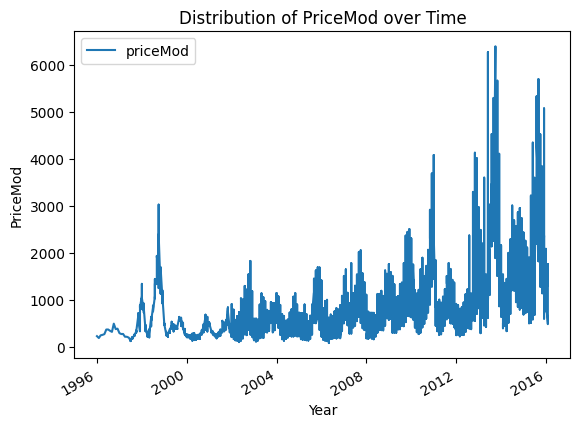

In [10]:
# What is the distribution of pricesMod over the years?


data.plot(x='date', y='priceMod')
plt.xlabel('Year')
plt.ylabel('PriceMod')
plt.title('Distribution of PriceMod over Time')
plt.show()

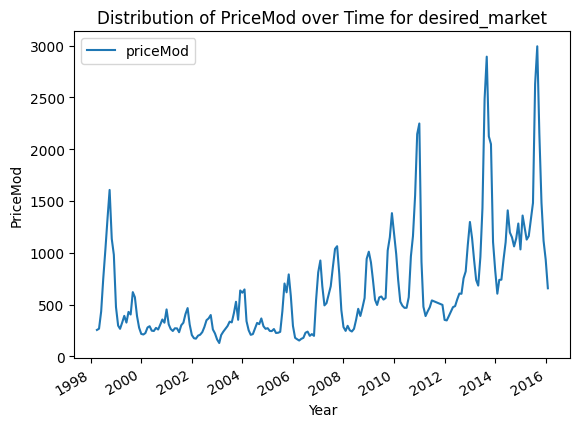

In [11]:
# what is the distribution of pricesMod over time by a given market?

market = 'MAHUVA(GUJ)'
data_subset = data[data['market'] == market]


# Plot the distribution of priceMod over time
data_subset.plot(x='date', y='priceMod')
plt.xlabel('Year')
plt.ylabel('PriceMod')
plt.title('Distribution of PriceMod over Time for desired_market')
plt.show()

In [12]:
# # Visualizing the relationships between multiple numeric variables in the dataset.
# sns.pairplot(data)
# plt.show()


# Feature Engineering

In [13]:
# Create relevant features such as lagged variables,

data['quantity_lag1'] = data.groupby('market')['quantity'].shift(1)

data['price_min_lag1'] = data.groupby('market')['priceMin'].shift(1)

data['price_max_lag1'] = data.groupby('market')['priceMax'].shift(1)


In [14]:
# Rolling Statistics
window_size = 3
data['priceMin_roll_mean'] = data.groupby('market')['priceMin'].transform(lambda x: x.rolling(window=window_size).mean())
data['priceMax_roll_std'] = data.groupby('market')['priceMax'].transform(lambda x: x.rolling(window=window_size).std())


In [15]:
# Replace NaNs with the mean
numeric_cols = data.select_dtypes(include=['number']).columns

data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())
data.head(5)

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,quantity_lag1,price_min_lag1,price_max_lag1,price_range,price_mean,priceMin_roll_mean,priceMax_roll_std
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,2005-01-01,76673.537152,642.587613,1205.074998,89,448.5,642.050969,561.434345
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,2006-01-01,2350.000000,404.000000,493.000000,151,562.5,642.050969,561.434345
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,2010-01-01,900.000000,487.000000,638.000000,309,1437.5,724.666667,597.068114
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,2011-01-01,790.000000,1283.000000,1592.000000,683,3408.5,1612.333333,1594.345425
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,2012-01-01,245.000000,3067.000000,3750.000000,163,604.5,1624.333333,1574.055060


In [16]:
# Extract seasonal features
data['month'] = data['date'].dt.month
data['quarter'] = data['date'].dt.quarter

data.head(5)

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,quantity_lag1,price_min_lag1,price_max_lag1,price_range,price_mean,priceMin_roll_mean,priceMax_roll_std,quarter
0,ABOHAR(PB),1,2005,2350,404,493,446,PB,ABOHAR,2005-01-01,76673.537152,642.587613,1205.074998,89,448.5,642.050969,561.434345,1
1,ABOHAR(PB),1,2006,900,487,638,563,PB,ABOHAR,2006-01-01,2350.000000,404.000000,493.000000,151,562.5,642.050969,561.434345,1
2,ABOHAR(PB),1,2010,790,1283,1592,1460,PB,ABOHAR,2010-01-01,900.000000,487.000000,638.000000,309,1437.5,724.666667,597.068114,1
3,ABOHAR(PB),1,2011,245,3067,3750,3433,PB,ABOHAR,2011-01-01,790.000000,1283.000000,1592.000000,683,3408.5,1612.333333,1594.345425,1
4,ABOHAR(PB),1,2012,1035,523,686,605,PB,ABOHAR,2012-01-01,245.000000,3067.000000,3750.000000,163,604.5,1624.333333,1574.055060,1


In [17]:
def plot_seasonality(time_period, unit):
  period_price_mod = data.groupby(f'{time_period}')[f'{unit}'].mean()
  plt.figure(figsize=(10, 6))
  period_price_mod.plot(kind='bar',color='skyblue')

  time_period = time_period.capitalize()
  plt.title(f'Seasonality of {unit} by {time_period}')
  plt.xlabel(f'{time_period}')
  plt.ylabel(f'Mean {unit}')
  plt.xticks(rotation=0)
  plt.grid(axis='y', linestyle='--', alpha=0.7)

  plt.show()

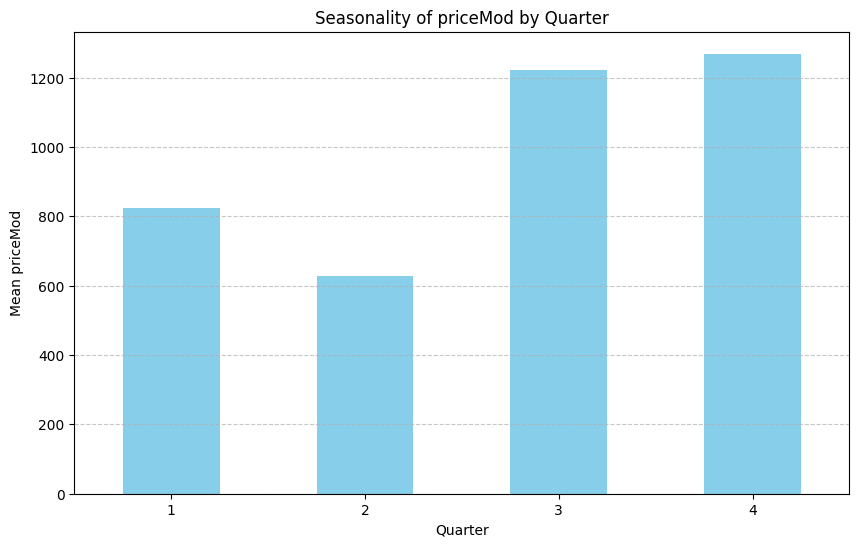

In [18]:
plot_seasonality('quarter', 'priceMod')

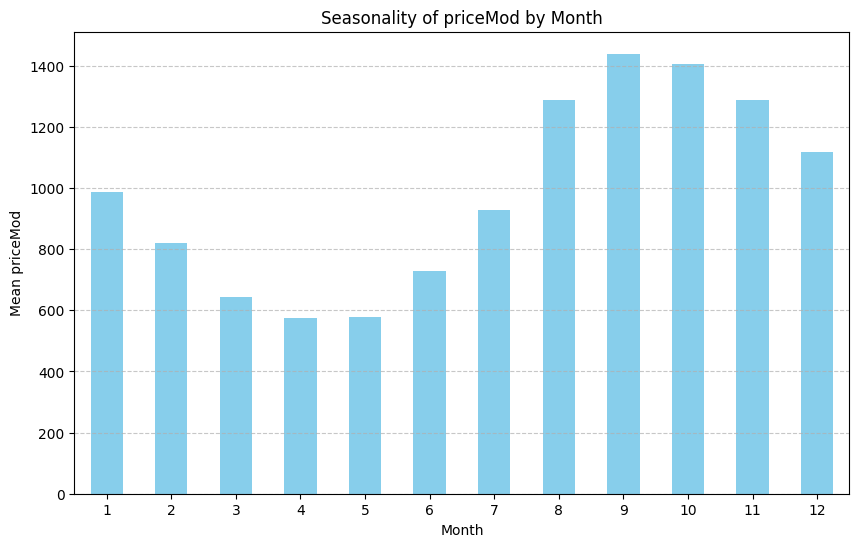

In [19]:
plot_seasonality('month', 'priceMod')

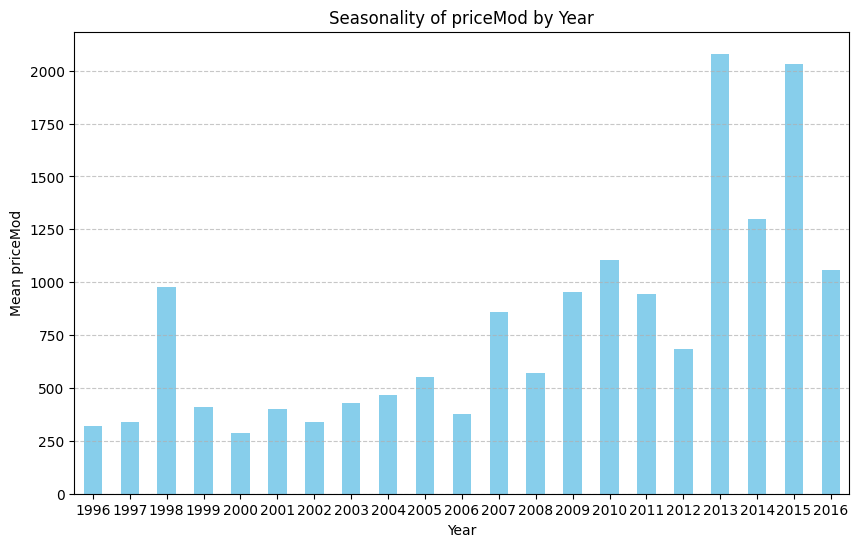

In [20]:
plot_seasonality('year', 'priceMod')

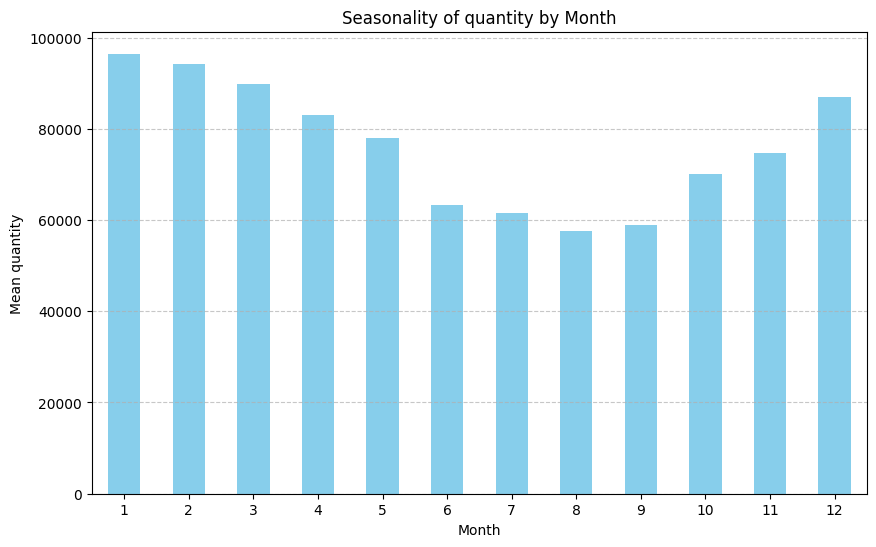

In [21]:
plot_seasonality('month', 'quantity')

# Model Selection

Model Selection and Training: Evaluating various time series forecasting models such as ARIMA,
SARIMA, Prophet, and LSTM, selecting the most suitable one, and training it on the dataset.

### Utilities

In [22]:
at_data = data.set_index('date')


In [23]:
average_priceMod = at_data.groupby('date')['priceMod'].mean()
print(average_priceMod)


date
1996-01-01     226.000000
1996-02-01     186.000000
1996-03-01     243.000000
1996-04-01     254.000000
1996-05-01     269.000000
                 ...     
2015-10-01    2838.788889
2015-11-01    2101.056180
2015-12-01    1427.516129
2016-01-01    1186.457831
2016-02-01     926.345679
Name: priceMod, Length: 242, dtype: float64


In [24]:
average_priceMod.index = pd.to_datetime(average_priceMod.index)
average_priceMod[:12]

date
1996-01-01    226.0
1996-02-01    186.0
1996-03-01    243.0
1996-04-01    254.0
1996-05-01    269.0
1996-06-01    367.0
1996-07-01    368.0
1996-08-01    340.0
1996-09-01    317.0
1996-10-01    492.0
1996-11-01    376.0
1996-12-01    385.0
Name: priceMod, dtype: float64

In [25]:
average_priceMod = average_priceMod.asfreq(freq='M', method='pad')
average_priceMod[:12]

date
1996-01-31    226.0
1996-02-29    186.0
1996-03-31    243.0
1996-04-30    254.0
1996-05-31    269.0
1996-06-30    367.0
1996-07-31    368.0
1996-08-31    340.0
1996-09-30    317.0
1996-10-31    492.0
1996-11-30    376.0
1996-12-31    385.0
Freq: M, Name: priceMod, dtype: float64

In [26]:
# Check for stationarity
result = adfuller(average_priceMod)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.400281585430931
p-value: 0.5821411154851405


In [27]:
# Differencing if needed
if result[1] > 0.05:
  average_priceMod = average_priceMod.diff().dropna()
average_priceMod

date
1996-02-29     -40.000000
1996-03-31      57.000000
1996-04-30      11.000000
1996-05-31      15.000000
1996-06-30      98.000000
                 ...     
2015-09-30     272.378749
2015-10-31   -1061.396678
2015-11-30    -737.732709
2015-12-31    -673.540051
2016-01-31    -241.058298
Freq: M, Name: priceMod, Length: 240, dtype: float64

In [28]:
# Plotting
def plot_results(train, test, predictions, title):
  plt.figure(figsize=(10, 6))
  plt.plot(train, label='Train', color='blue')
  plt.plot(test, label='Test', color='green')
  plt.plot(test.index, predictions, label='Predictions', color='red')
  plt.legend()
  plt.title(f'{title}')
  plt.xlabel('Date')
  plt.ylabel('priceMod')
  plt.show()

### ARIMA

In [29]:
# Split the data
train_size = int(len(average_priceMod) * 0.8)
train, test = average_priceMod[:train_size], average_priceMod[train_size:]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RMSE: 500.76774029582356


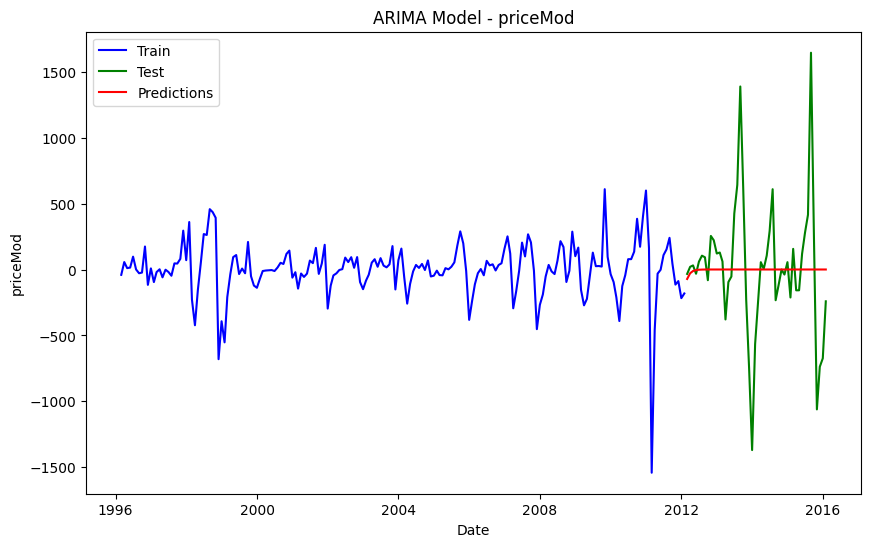

In [30]:
# Fit the ARIMA model
model = ARIMA(train, order=(1, 1, 1))  # (p, d, q) order
model_fit = model.fit()

# Step 5: Evaluate the model
predictions = model_fit.forecast(steps=len(test))
# test = test[1:]  # Align test size with predictions size

mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

plot_results(train, test, predictions, 'ARIMA Model - priceMod')

### SARIMA

RMSE: 488.40662277708003


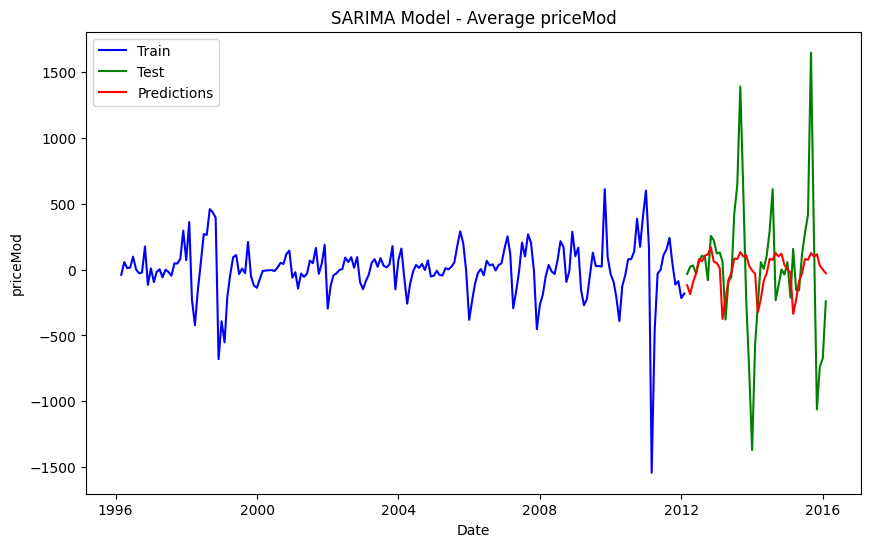

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# Fit the SARIMA model
model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

# Step 4: Forecast future values
predictions = model_fit.forecast(steps=len(test))

# Step 5: Evaluate the model's performance
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

plot_results(train, test, predictions, 'SARIMA Model - Average priceMod')

### Prophet

In [32]:
!pip install prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw57ry61n/tn4f1m4h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw57ry61n/rc73yfof.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9767', 'data', 'file=/tmp/tmpw57ry61n/tn4f1m4h.json', 'init=/tmp/tmpw57ry61n/rc73yfof.json', 'output', 'file=/tmp/tmpw57ry61n/prophet_model5ljf6p_s/prophet_model-20240529120538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:05:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 2246.793894095082


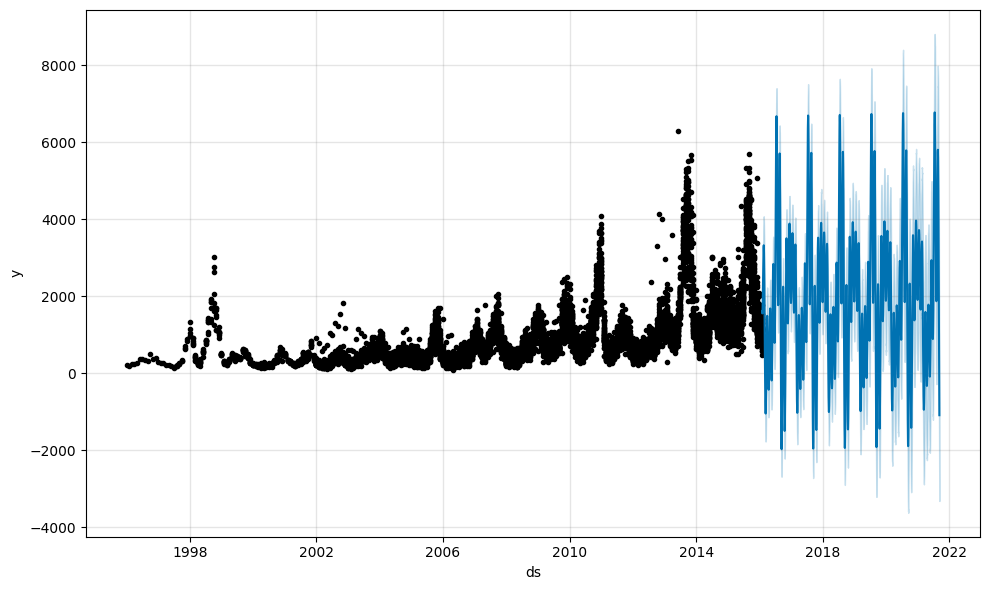

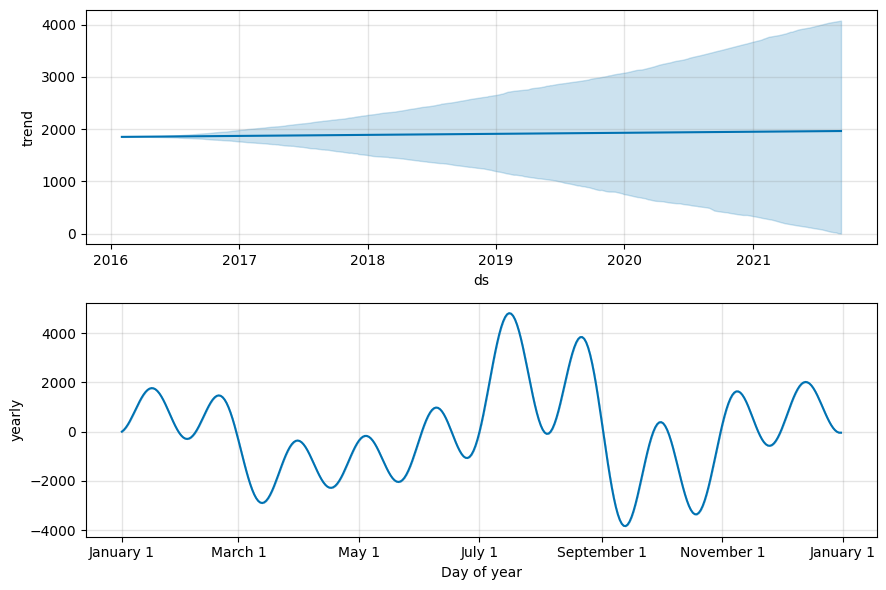

In [33]:
from prophet import Prophet
from prophet.plot import plot, plot_components

prophet_data = data[['date', 'priceMod']]
prophet_data.columns = ['ds', 'y']

# Split the data into training and testing sets
train_size = int(len(prophet_data) * 0.8)  # 80% for training, 20% for testing
train = prophet_data.iloc[:train_size]
test = prophet_data.iloc[train_size:]


# Initialize and fit Prophet model
model = Prophet()
model.fit(train)

# Create a future DataFrame
future = model.make_future_dataframe(periods=len(test), include_history=False)

# Generate predictions
forecast = model.predict(future)

# Evaluation
# Plotting forecast
fig = model.plot(forecast)

# Plotting components
fig = model.plot_components(forecast)

# Calculate RMSE
y_true = test['y'].values
y_pred = forecast['yhat'].values
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')


#### Try adding more features

In [34]:
# model.add_regressor('market')
# model.add_regressor('quantity')
# model.add_regressor('priceMin')

### LSTM

In [32]:
data

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,quantity_lag1,price_min_lag1,price_max_lag1,price_range,price_mean,priceMin_roll_mean,priceMax_roll_std,quarter
0,ABOHAR(PB),1,2005,2350,404,493,446,PB,ABOHAR,2005-01-01,76673.537152,642.587613,1205.074998,89,448.5,642.050969,561.434345,1
1,ABOHAR(PB),1,2006,900,487,638,563,PB,ABOHAR,2006-01-01,2350.000000,404.000000,493.000000,151,562.5,642.050969,561.434345,1
2,ABOHAR(PB),1,2010,790,1283,1592,1460,PB,ABOHAR,2010-01-01,900.000000,487.000000,638.000000,309,1437.5,724.666667,597.068114,1
3,ABOHAR(PB),1,2011,245,3067,3750,3433,PB,ABOHAR,2011-01-01,790.000000,1283.000000,1592.000000,683,3408.5,1612.333333,1594.345425,1
4,ABOHAR(PB),1,2012,1035,523,686,605,PB,ABOHAR,2012-01-01,245.000000,3067.000000,3750.000000,163,604.5,1624.333333,1574.055060,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10222,YEOLA(MS),12,2011,131326,282,612,526,MS,YEOLA,2011-12-01,57586.000000,541.000000,2713.000000,330,447.0,434.000000,1053.035770,4
10223,YEOLA(MS),12,2012,207066,485,1327,1136,MS,YEOLA,2012-12-01,131326.000000,282.000000,612.000000,842,906.0,436.000000,1068.208937,4
10224,YEOLA(MS),12,2013,215883,472,1427,1177,MS,YEOLA,2013-12-01,207066.000000,485.000000,1327.000000,955,949.5,413.000000,444.494094,4
10225,YEOLA(MS),12,2014,201077,446,1654,1456,MS,YEOLA,2014-12-01,215883.000000,472.000000,1427.000000,1208,1050.0,467.666667,167.559940,4


In [ ]:
# One-Hot Encoding for categorical variables
encoder = OneHotEncoder()
encoded_categories = encoder.fit_transform(data[['market', 'state', 'city', 'month', 'year', 'quarter']]).toarray()
encoded_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(['market', 'state', 'city', 'month', 'year', 'quarter']))


In [25]:
# Normalize numerical features
data_numeric = data.drop(columns=['market', 'state', 'city', 'month', 'year', 'quarter', 'date'])

scaler = MinMaxScaler()
data_numeric_normalized = pd.DataFrame(scaler.fit_transform(data_numeric), columns=data_numeric.columns)

In [ ]:
# Combine encoded categorical variables with the numerical ones
lstm_data = pd.concat([data['date'], data_numeric_normalized, encoded_df], axis=1)

In [30]:
# Check if lstm_data has any null or NaN values
print('Null values are present') if lstm_data.isnull().sum().sum() else print('No null values')


No null values


In [33]:
# Separate features and target variable
X_data = lstm_data
y_data = lstm_data['priceMod']

In [34]:
# Convert the data to sequences
def create_sequences(X, y, seq_length):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        x = X[i:i+seq_length]
        y_ = y[i+seq_length]
        xs.append(x)
        ys.append(y_)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 12  # Sequence length of 12 months
X, y = create_sequences(X_data, y_data, SEQ_LENGTH)

In [35]:
# Split the data into training and testing sets
TRAIN_SPLIT = int(0.8 * len(X))
X_train, X_test = X[:TRAIN_SPLIT], X[TRAIN_SPLIT:]
y_train, y_test = y[:TRAIN_SPLIT], y[TRAIN_SPLIT:]

In [67]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
256/256 [==============================] - 5s 14ms/step - loss: 0.0096
Epoch 2/10
256/256 [==============================] - 6s 22ms/step - loss: 0.0046
Epoch 3/10
256/256 [==============================] - 4s 16ms/step - loss: 0.0037
Epoch 4/10
256/256 [==============================] - 4s 16ms/step - loss: 0.0031
Epoch 5/10
256/256 [==============================] - 4s 14ms/step - loss: 0.0026
Epoch 6/10
256/256 [==============================] - 6s 23ms/step - loss: 0.0023
Epoch 7/10
256/256 [==============================] - 3s 13ms/step - loss: 0.0021
Epoch 8/10
256/256 [==============================] - 3s 14ms/step - loss: 0.0019
Epoch 9/10
256/256 [==============================] - 4s 15ms/step - loss: 0.0018
Epoch 10/10
256/256 [==============================] - 7s 28ms/step - loss: 0.0017


In [75]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
categorical_columns = ['market', 'state', 'city', 'month', 'year', 'quarter']
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, X_test.shape[2]))
y_pred_inverse = scaler.inverse_transform(np.hstack([X_test.reshape(-1, X_test.shape[2]), y_pred])).reshape(-1, X_test.shape[2] + 1)[:, -1]


# Extract the priceMod column
priceMod_index = lstm_data.columns.get_loc('priceMod')
y_test_priceMod = y_test_inverse[:, priceMod_index]
y_pred_priceMod = y_pred_inverse

# Calculate evaluation metrics
mse = mean_squared_error(y_test_priceMod, y_pred_priceMod)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_priceMod, y_pred_priceMod)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

64/64 [==============================] - 2s 26ms/step


ValueError: cannot reshape array of size 2043 into shape (305)

### Best Model

# Fine-tuning and Validation:

Fine-tuning the model parameters, validating its performance on unseen
data, and iterating if necessary.